## PR FP - EXPERIMENT B
### Hall-Effekt und Leitfähigkeit
Universität Innsbruck - SS 2025

In [1024]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import constants
import matplotlib.pyplot as plt

 # für numerisches Lösen von Gleichung
from scipy.optimize import fsolve
from scipy.optimize import root_scalar
import scipy.optimize as opt

# Fehlerfortpflanzung in Python
from uncertainties import ufloat
import uncertainties.umath as um
from uncertainties import unumpy, wrap # für Funktionen

plt.rcParams['text.usetex'] = True #LaTeX

In [1025]:
# Schrifarten für Plots
font1 = {'family':'sans-serif','color':'black','size':12}
font2 = {'family':'sans-serif','color':'black','size':20}

In [1026]:
# Einlesen der Rohdaten als Wert +/- Fehler
df = pd.read_csv("PR-FP-data-ExpB.csv")

# Das hier macht Liste aus Daten...
""" R1 = [ufloat(x, y) for x, y in zip(df['R1'], df['R1_ERROR'])]
U_CD_1 = [ufloat(x, y) for x, y in zip(df['U_CD-1'], df['U_CD-1_ERROR'])] # Konfiguration 1a
U_CD_2 = [ufloat(x, y) for x, y in zip(df['U_CD-2'], df['U_CD-2_ERROR'])] # Konfiguration 1b
U_AD_1 = [ufloat(x, y) for x, y in zip(df['U_AD-1'], df['U_AD-1_ERROR'])] # Konfiguration 2a
U_AD_2 = [ufloat(x, y) for x, y in zip(df['U_AD-2'], df['U_AD-2_ERROR'])] # Konfiguration 2b
R2 = [ufloat(x, y) for x, y in zip(df['R2'], df['R2_ERROR'])]
U_BD_0_1 = [ufloat(x, y) for x, y in zip(df['U_BD_0-1'], df['U_BD_0-1_ERROR'])] # Konfiguration 3a OHNE Magnetfeld
U_BD_0_2 = [ufloat(x, y) for x, y in zip(df['U_BD_0-2'], df['U_BD_0-2_ERROR'])] # Konfiguration 3b OHNE Magnetfeld
U_BD_B_1 = [ufloat(x, y) for x, y in zip(df['U_BD_B-1'], df['U_BD_B-1_ERROR'])] # Konfiguration 3a MIT Magnetfeld
U_BD_B_2 = [ufloat(x, y) for x, y in zip(df['U_BD_B-2'], df['U_BD_B-2_ERROR'])] # Konfiguration 3b MIT Magnetfeld """

# Das hier macht 1x33 Pandas-DF aus Daten...
R1 = df.apply(lambda row: ufloat(row['R1'], row['R1_ERROR']), axis=1)
U_CD_1 = df.apply(lambda row: ufloat(row['U_CD-1'], row['U_CD-1_ERROR']), axis=1) # Konfiguration 1a
U_CD_2 = df.apply(lambda row: ufloat(row['U_CD-2'], row['U_CD-2_ERROR']), axis=1) # Konfiguration 1b
U_AD_1 = df.apply(lambda row: ufloat(row['U_AD-1'], row['U_AD-1_ERROR']), axis=1) # Konfiguration 2a
U_AD_2 = df.apply(lambda row: ufloat(row['U_AD-2'], row['U_AD-2_ERROR']), axis=1) # Konfiguration 2b
R2 = df.apply(lambda row: ufloat(row['R2'], row['R2_ERROR']), axis=1)
U_BD_0_1 = df.apply(lambda row: ufloat(row['U_BD_0-1'], row['U_BD_0-1_ERROR']), axis=1) # Konfiguration 3a OHNE Magnetfeld
U_BD_0_2 = df.apply(lambda row: ufloat(row['U_BD_0-2'], row['U_BD_0-2_ERROR']), axis=1) # Konfiguration 3b OHNE Magnetfeld
U_BD_B_1 = df.apply(lambda row: ufloat(row['U_BD_B-1'], row['U_BD_B-1_ERROR']), axis=1) # Konfiguration 3a MIT Magnetfeld
U_BD_B_2 = df.apply(lambda row: ufloat(row['U_BD_B-2'], row['U_BD_B-2_ERROR']), axis=1) # Konfiguration 3b MIT Magnetfeld

In [1027]:
print('Anzahl an Messpunkten: ' + str(len(df)))

Anzahl an Messpunkten: 33


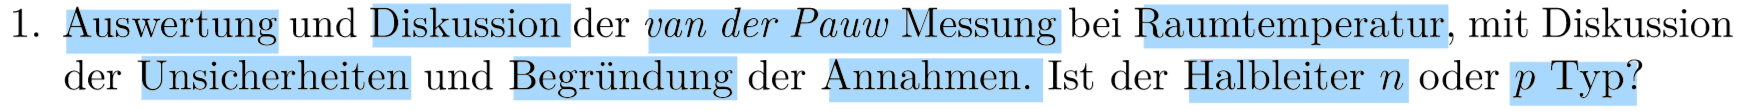

Obwohl im Laufe einer Messreihe die Temperatur und damit der Widerstand des Pt100-Bauteils kontinuierlich gesunken ist, entschieden wir uns beide gemessenen Widerstandswerte zu mitteln und diesen für unsere gesamte Datenauswertung- als auch Darstellung zu verwenden. Es bestünde noch die Möglichkeit, die spezifische Leitfähigkeit mit dem ersten und den Hall-Koeffzienten mit dem zweiten Messwert zu berechen, um je möglichst exate Resultate zu erhalten. Nicht desto trotz müssen wir bei der Kombination der beiden Messwerte für unsere weiteren Untersuchungen so oder so einen kombinierten Temperaturwert verwenden, was uns dazu führte, ab hier nur mehr mit dem Durchschnittswert zu arbeiten.

Wir sehen das Abfallen der Temperatur während eines Messdurchlaufs als entscheidende Fehlerquelle. Abhilfe würde hier eine (automatisierte) Versuchsanordnung helfen, die uns hilft, die Messwerte möglichst parallel bzw. in kleinem zeitlichen Abstand zu messen.

`R` ist jener Widerstand inkl. Fehler, mit der die gesamte restliche Auswertung passiert.

In [1028]:
R = (R1 + R2) / 2 # ... das in Funktion 'calibration_curve' zu packen war nicht möglich :(

## 1. Umrechnung Widerstand in Temperatur

Der Fehler des Widerstandes setzt sich einerseits aus den direkt ablesbaren Messwertschwankungen, andererseits aus des verwendeten Multimeters FLUKE 8840A zusammen. Dieser liegt laut Bedienungsanleitung bei $0,014 \%$ im gegebenen Messintervall liegt. Dies Fehler wurde nach Regeln der Gauß'schen Fehlerfortpflanzung quadratisch kombiniert.

### Kalibrierungskurve: $T(R)=\frac{509}{8}-\frac{89}{2R}+\frac{43}{30}\sqrt{R}+\frac{161}{113}R^{\frac{11}{10}}$

Dem Skript entsprechend setzten wir die Unsicherheit der Kalibrierungskurve mit $0,2 \%$ über $70 \: K$ und $1 \%$ unter $70 \: K$ an. Der Gesamtfehler ergibt sich somit einerseits aus den Messwertschwankungen des Widerstandes, andererseits aus der Unsicherheit der Kalibrierungskurve. Diese wurde gemäß Gauß'scher Fehlerpropagation kombiniert. 

Funktion von `calibration_curve`:
1. Fehler von Ablesen und Multimeter für Widerstand kombiniert
2. Temperatur laut Kalibrierungskurve rechnet
3. Fehler von Widerstand und Kurve für Temperatur kombiniert

In [1029]:
@wrap
def calibration_curve(resistance, error_threshold, error_up, error_down, error_multimeter):
    # Kombination von Messwertschwankung und Multimeter-Fehler
    resistance_value = resistance.apply(lambda x: x.nominal_value) # Werte extrahieren
    resistance_std_dev = resistance.apply(lambda x: x.std_dev) # Unsicherheiten extrahieren
    resistance_std_dev_new = np.sqrt(resistance_std_dev ** 2 + (resistance_value * error_multimeter) ** 2) # Fehlerkombination lt. Carl Friedrich
    resistance_new = pd.Series([ufloat(v, e) for v, e in zip(resistance_value, resistance_std_dev)])  # Zusammensetzen zu neuem ufloat-Objekt & Umwandlung in Pandas-DF

    # Berechnung der Temperatur mit Fehlerfortpflanzung
    temperature = (
        509 / 8
        - 89 / (2 * resistance_new)
        + (43 / 30) * resistance_new.apply(lambda x: um.sqrt(x))
        + (161 / 113) * resistance_new ** (11 / 10)
    )

    # Werte und Unsicherheiten extrahieren
    temperature_value = temperature.apply(lambda x: x.nominal_value)
    temperature_std_dev = temperature.apply(lambda x: x.std_dev)

    """ # Debugging-Ausgabe
    print(f'Temperature only with resistance errors: {temperature.iloc[1]} K')
    print(f'Temperature only with resistance errors: {temperature_value.iloc[1]} +/- {temperature_std_dev.iloc[1]} K') """

    # Zusätzliche Fehlerfortpflanzung mit Bedingung
    temperature_new_error = np.where(
        temperature_value > error_threshold,
        np.sqrt((temperature_value * error_up) ** 2 + temperature_std_dev ** 2),
        np.sqrt((temperature_value * error_down) ** 2 + temperature_std_dev ** 2),
    )

    # ufloat-Objekte wieder zusammensetzen
    temperature_new = [ufloat(v, e) for v, e in zip(temperature_value, temperature_new_error)]

    return temperature_new

`temperature` ist jene Temperatur inkl. Fehler, mit der die gesamte restliche Auswertung ab hier passiert.

In [1030]:
T_error_70plus = 0.2 / 100 # Fehler 0,2% für T > 70 K
T_error_70minus = 1 / 100 # Fehler 1% für T < 70 K
T_error_threshold = 70 # K
error_multimeter_R = 0.014 / 100 # Fehler lt. Bedienungsanleitung FLUKE 8840A

temperature = calibration_curve(R, T_error_threshold, T_error_70plus, T_error_70minus, error_multimeter_R)

max_temperature = max(temperature, key=lambda x: x.nominal_value)
min_temperature = min(temperature, key=lambda x: x.nominal_value)
print(f'Maximale Temperatur: {max_temperature} K')
print(f'Minimale Temperatur: {min_temperature} K')

Maximale Temperatur: 323.7+/-0.6 K
Minimale Temperatur: 87.69+/-0.18 K


## 2. Berechnung der Spannungen, mit denen wir arbeiten
Die Unsicherheit der gemessen Spannungen schätzen wir wieder einerseits durch die am Multimeter abgelesene Messwertschwankung zu $0,001 \: \mathrm{mV}$ für die ersten 21 respektive mit $0,005 \: \mathrm{mV}$ für die letzten Datenpunkte 12 ab. Weiters berücksichtigen wir den Fehler der vom Messgerät selbst herrührt, welcher bei $0,008 \%$ des Messwerts liegt. Beide Unsicherheiten wurde quadratisch kombiniert.

`voltage_uncertaint` rechnet kombinierten Fehler aus.

In [1031]:
@wrap
def voltage_uncertainty(voltage, error_multimeter):
    voltage_value = voltage.apply(lambda x: x.nominal_value) # Werte extrahieren
    voltage_std_dev = voltage.apply(lambda x: x.std_dev) # Unsicherheiten extrahieren
    voltage_std_dev_new = np.sqrt(voltage_std_dev ** 2 + (voltage_value * error_multimeter) ** 2) # Fehlerkombination lt. Carl Friedrich
    voltage_new = pd.Series([ufloat(v, e) for v, e in zip(voltage_value, voltage_std_dev_new)])  # Zusammensetzen zu neuem ufloat-Objekt & Umwandlung in Pandas-DF
    return voltage_new

In [1032]:
error_multimeter_U = 0.008 / 100 # Fehler lt. Bedienungsanleitung FLUKE 8840A

# Spannungswerte mit kombinierten Fehlern
U_CD_1_new = voltage_uncertainty(U_CD_1,error_multimeter_U)
U_CD_2_new = voltage_uncertainty(U_CD_2,error_multimeter_U)
U_AD_1_new = voltage_uncertainty(U_AD_1,error_multimeter_U)
U_AD_2_new = voltage_uncertainty(U_AD_2,error_multimeter_U)
U_BD_0_1_new = voltage_uncertainty(U_BD_0_1,error_multimeter_U)
U_BD_0_2_new = voltage_uncertainty(U_BD_0_2,error_multimeter_U)
U_BD_B_1_new = voltage_uncertainty(U_BD_B_1,error_multimeter_U)
U_BD_B_2_new = voltage_uncertainty(U_BD_B_2,error_multimeter_U)

Wir rechneten hierfür immer den Durchschnitt der Beträge der Spannungen beider Polungen aus. Konkret haben wir den Mittelwert der Beträge der Spannungen aus den Konfigurations-Paaren 1a und 1b, 2a und 2b, 3a und 3b (je mit und ohne Magnetfeld) berechnet. Bei den Spannungen für die Konfigurationen 1a, 1b, 2a und 2b haben wir rigoros für alle Werte ihre Beträge verwendet, da man in der weiteren Auswertung sowieso nur den Betragwert einer Größe wissen möchte. Jedoch muss beachtet werden, dass dies für die Konfigurationen 3a und 3b sowohl mit als auch ohne Magnetfeld keinesfalls so getan werden darf, da für unserer Untersuchungen genau entscheidend ist, ob der Spannungswert positiv oder negativ ist. Deswegen haben wir für die Bildung des Durchschnitts nur den Betrag des Spannungswerts der Konfiguration 3b (jeweils mit und ohne Magnetfeld) verwendet; das Vorzeichen des Mittelwerts entspricht damit den Spannungswert der Konfiguration 3a.

In [1033]:
U_CD = (U_CD_1_new.apply(abs) + U_CD_2_new.apply(abs)) / 2 # Konfiguration 1
U_AD = (U_AD_1_new.apply(abs) + U_AD_2_new.apply(abs)) / 2 # Konfiguration 2
U_BD_0 = (U_BD_0_1_new + U_BD_0_2_new.apply(abs)) / 2 # Konfiguration 3 OHNE Magnetfeld
U_BD_B = (U_BD_B_1_new + U_BD_B_2_new.apply(abs)) / 2 # Konfiguration 3 MIT Magnetfeld

## 3. Berechnung des spezifischen Widerstandes

Für den gesamten Versuch legen wir einen Strom von $I=500 \: \mu A$ an dem Halbleiter an. Es gilt, dass $I=I_\mathrm{AB}=I_\mathrm{BC}$ ist. Gemäß dem Datenblatt unserer Stromqeulle Keithley 224 ergibt sich die Unsicherheit in des verwendeten Stroms im entsprechenden Intervall $100 \: \mu A \pm 199,95 \: \mu A$ zu $\pm 0,005 \%$ für das Ablesen und $+100 \: nA$ für den Offset als Fehler, also einem Gesamtfehler von $\pm (0,25 \: \mu A + 0,1 \: \mu A) = \pm 0,35 \mu A$. Dem entsprechend können wir den Strom zu $I = (500 \pm 0.35) \: \mu A$ bestimmen.



In [1034]:
current_value = 500 * 10 ** -6 # A
current_error = 0.35 * 10 ** -6 # A
current = ufloat(current_value, current_error) # kombiniert 2 Variablen zu ufloat-Objekt

Widerstände werden lt. Skript berechnet:

In [1035]:
R_ABCD = (U_CD / current).apply(abs)
R_BCDA = (U_AD / current).apply(abs)

# Ein Versuch, das Ganze mit Liste anstatt Pandas-DF zu machen... 
""" LIST_R_ABCD = [ufloat(x, y) for x, y in zip(R_ABCD.apply(lambda x: x.nominal_value), R_ABCD.apply(lambda x: x.std_dev))]
LIST_R_BCDA = [ufloat(x, y) for x, y in zip(R_BCDA.apply(lambda x: x.nominal_value), R_BCDA.apply(lambda x: x.std_dev))] """

' LIST_R_ABCD = [ufloat(x, y) for x, y in zip(R_ABCD.apply(lambda x: x.nominal_value), R_ABCD.apply(lambda x: x.std_dev))]\nLIST_R_BCDA = [ufloat(x, y) for x, y in zip(R_BCDA.apply(lambda x: x.nominal_value), R_BCDA.apply(lambda x: x.std_dev))] '

### $\rho = \frac{\pi d}{\ln 2}\frac{R_\mathrm{AB,CD}+R_\mathrm{BC,DA}}{2}f$

In [1036]:
# Wird nicht verwendet, da nicht funktioniert...
@wrap
def specific_resistance(d, R_ABCD, R_BCDA, f):
    rho = ((np.pi * d) / np.log(2)) * ((R_ABCD + R_BCDA) / 2) * f
    return rho

### Lösung der transzendenten Gleichung:
### $\cosh{\biggl( \frac{\ln{2}}{f}\frac{x-1}{x+1} \biggr)}= \frac{1}{2}\exp{\biggl( \frac{\ln{2}}{f} \biggr)}$ mit $x = \frac{R_\mathrm{AB,CD}}{R_\mathrm{BC,DA}}$

Da wir diese Gleichung numerisch in `Python` mittels der im Paket `scipy` implementierten Funktion `fsolve` lösen, ist es hier schwierig, einen mathematisch korrekten Fehler abzuschätzen.

In [1037]:
@wrap
def equation(x, f):
    left_side = np.cosh((np.log(2) / f) * (x - 1) / (x + 1))
    right_side = 0.5 * np.exp(np.log(2) / f)
    return left_side - right_side

In [1038]:
# Funktion, um die Gleichung für jedes Element im ufloat-Array zu lösen
@wrap
def solve_for_x(x_values, f_value):
    solutions = []
    for x in x_values:
        # Löse die Gleichung numerisch für jedes x
        solution = fsolve(equation, x.nominal_value, args=(f_value))
        # Setze die Lösung als ufloat-Wert, wobei wir die Unsicherheit als 0 annehmen (numerische Lösung ohne Unsicherheit)
        solutions.append(ufloat(solution[0], 0))  # Unsicherheit für die Lösung könnte später angepasst werden
    return solutions

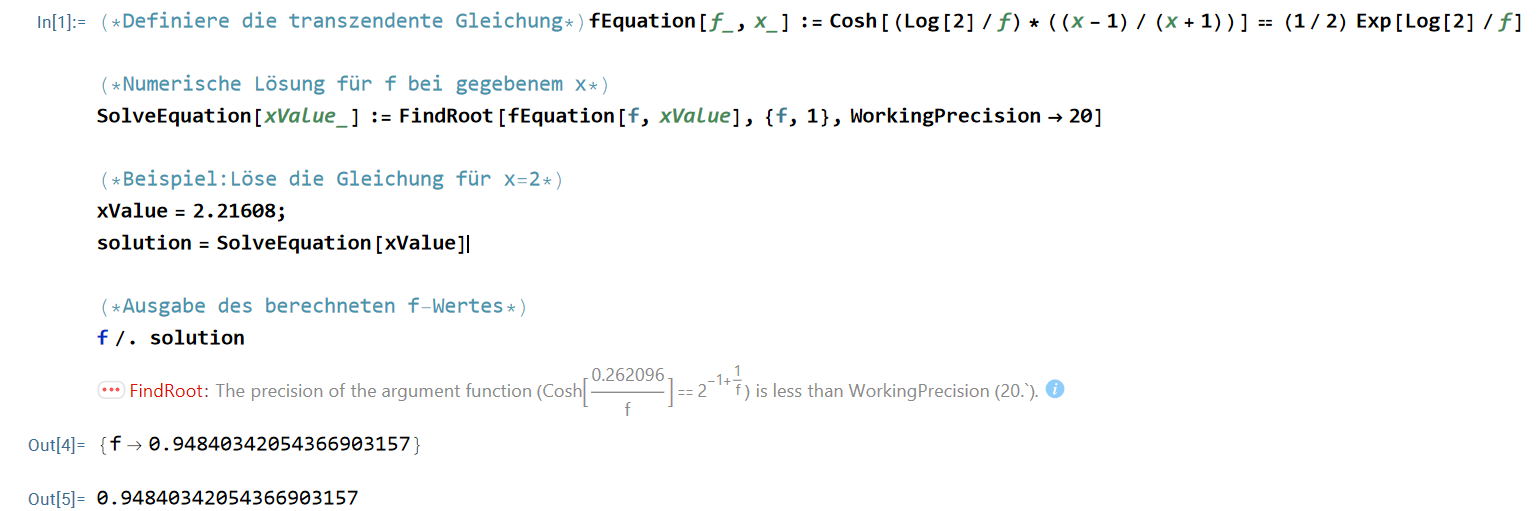

In [1039]:
f_start = 0.94840342054366903157  # Startwert lt. Mathematica für Lösung mit 'fsolve'
x = R_ABCD / R_BCDA

print('Funktionswert für x_0 = ' + str(x[0]) + ': ' + str(equation(2.21608, 0.94840342054366903157)))

f_solutions = solve_for_x(x, f_start)

for i, sol in enumerate(f_solutions):
    print(f"Die Lösung für x_{i+1} ist: {sol}")

Funktionswert für x_0 = 2.21608+/-0.00023: 0.0
Die Lösung für x_1 ist: 2.2160800000000034+/-0
Die Lösung für x_2 ist: 2.2160800000000016+/-0
Die Lösung für x_3 ist: 2.2160800000000034+/-0
Die Lösung für x_4 ist: 2.2160800000000016+/-0
Die Lösung für x_5 ist: 2.2160799999999705+/-0
Die Lösung für x_6 ist: 2.2160800000000016+/-0
Die Lösung für x_7 ist: 2.2160800000000025+/-0
Die Lösung für x_8 ist: 2.2160800000000007+/-0
Die Lösung für x_9 ist: 2.216079999999999+/-0
Die Lösung für x_10 ist: 2.216079999999999+/-0
Die Lösung für x_11 ist: 2.2160799999999985+/-0
Die Lösung für x_12 ist: 2.216080000000001+/-0
Die Lösung für x_13 ist: 2.2160799999999985+/-0
Die Lösung für x_14 ist: 2.2160800000000003+/-0
Die Lösung für x_15 ist: 2.2160800000000034+/-0
Die Lösung für x_16 ist: 2.2160799999999994+/-0
Die Lösung für x_17 ist: 2.216079999999999+/-0
Die Lösung für x_18 ist: 2.2160800000000025+/-0
Die Lösung für x_19 ist: 2.216079999999989+/-0
Die Lösung für x_20 ist: 2.216080000000002+/-0
Die Lösu

## 2. Versuche transzendete Gleichung mit `root_scalar` zu lösen:

### GEHT AUCH NICHT!

In [1040]:
# Funktion zur Lösung von f für jedes x im DataFrame
def solve_for_f(x_values):
    solutions = []
    for x in x_values:
        
        sol = root_scalar(equation, args=(x.nominal_value,), bracket=[0.0001, 1000], method='brentq')
        
        if sol.converged:
            solutions.append(ufloat(sol.root, 0))  # Fehler könnte später hinzugefügt werden
        else:
            solutions.append(ufloat(np.nan, np.nan))  # Falls keine Lösung gefunden wird
        
    return pd.Series(solutions)

In [1041]:
""" # Lösungen für f berechnen
f_solutions_2 = solve_for_f(x)

# Ergebnisse ausgeben
print("Gefundene f-Werte:")
print(f_solutions_2) """

' # Lösungen für f berechnen\nf_solutions_2 = solve_for_f(x)\n\n# Ergebnisse ausgeben\nprint("Gefundene f-Werte:")\nprint(f_solutions_2) '

## 3. Versuche transzendete Gleichung mit `root_scalar` zu lösen:

### GEHT AUCH NICHT!

In [1042]:
# Funktion zur Lösung für f mit robustem Algorithmus
def solve_for_f2(x_values):
    solutions = []
    
    for x in x_values:
        x_nom = x.nominal_value  # Nominalwert aus ufloat extrahieren

        try:
            # 1. Versuche Newton-Methode mit Startwert nahe Mathematica-Lösung (0.95)
            sol = opt.root_scalar(equation, args=(x_nom,), x0=0.95, method='newton')
            
            if sol.converged:
                solutions.append(ufloat(sol.root, 0))  # Fehler später ergänzen
                continue

        except Exception:
            pass  # Falls Newton fehlschlägt, versuche Brent

        try:
            # 2. Falls Newton fehlschlägt: Brent-Algorithmus mit dynamischem Intervall
            sol = opt.root_scalar(equation, args=(x_nom,), bracket=[0.1, 2], method='brentq')
            
            if sol.converged:
                solutions.append(ufloat(sol.root, 0))
                continue

        except ValueError:
            print(f"x Kein Vorzeichenwechsel für x={x}. Lösung nicht gefunden.")
            solutions.append(ufloat(np.nan, np.nan))  # NaN, falls keine Lösung gefunden

    return np.array(solutions)

# Berechne Lösungen
f_solutions3 = solve_for_f2(x)

# Ausgabe
print("Gefundene f-Werte:")
print(f_solutions3)

x Kein Vorzeichenwechsel für x=2.21608+/-0.00023. Lösung nicht gefunden.
x Kein Vorzeichenwechsel für x=2.23037+/-0.00023. Lösung nicht gefunden.
x Kein Vorzeichenwechsel für x=2.21928+/-0.00024. Lösung nicht gefunden.
x Kein Vorzeichenwechsel für x=2.17677+/-0.00023. Lösung nicht gefunden.
x Kein Vorzeichenwechsel für x=2.21585+/-0.00024. Lösung nicht gefunden.
x Kein Vorzeichenwechsel für x=2.21447+/-0.00025. Lösung nicht gefunden.
x Kein Vorzeichenwechsel für x=2.21164+/-0.00025. Lösung nicht gefunden.
x Kein Vorzeichenwechsel für x=2.21248+/-0.00026. Lösung nicht gefunden.
x Kein Vorzeichenwechsel für x=2.20854+/-0.00026. Lösung nicht gefunden.
x Kein Vorzeichenwechsel für x=2.20884+/-0.00026. Lösung nicht gefunden.
x Kein Vorzeichenwechsel für x=2.20878+/-0.00027. Lösung nicht gefunden.
x Kein Vorzeichenwechsel für x=2.20518+/-0.00028. Lösung nicht gefunden.
x Kein Vorzeichenwechsel für x=2.20764+/-0.00028. Lösung nicht gefunden.
x Kein Vorzeichenwechsel für x=2.21457+/-0.00029. L

/home/jtilg/anaconda3/envs/comp_physics/lib/python3.13/site-packages/scipy/optimize/_root_scalar.py:327: RuntimeWarning: Derivative was zero.
  r, sol = methodc(f, x0, args=args, fprime=fprime, fprime2=None,


In [1043]:
 # Dicke der Probe in m
d_value = 5 * 10 ** -6
d_error = 10 ** -6
d = ufloat(d_value, d_error)

# Das alles funktioniert nicht ...
""" specific_resistance = specific_resistance(d, R_ABCD, R_BCDA, f_solutions)
spec_resistance = specific_resistance(d, LIST_R_ABCD, LIST_R_BCDA, f_solutions)
spec_resistance = df.apply(lambda row: specific_resistance(d, LIST_R_ABCD, LIST_R_BCDA, f_solutions), axis=1) """

# ... deswegen ohne Funktion:
spec_resistance = ((np.pi * d) / np.log(2)) * ((R_ABCD + R_BCDA) / 2) * f_solutions
conductibility = 1 / spec_resistance

print(f'Die Leitfähigkeit beim Raumtemperatur beträgt {conductibility[0]} S/m (Siemens pro Meter)')
print(f'Der spezifische Widerstand bei Raumtemperatur beträgt {spec_resistance[0]} Ohm * m')

Die Leitfähigkeit beim Raumtemperatur beträgt 0.53+/-0.11 S/m (Siemens pro Meter)
Der spezifische Widerstand bei Raumtemperatur beträgt 1.9+/-0.4 Ohm * m


## 4. Berechnung des Hall-Koeffizienten

In [1044]:
R_ACBD_0 = U_BD_0 / current
R_ACBD_B = U_BD_B / current

# Daten für das Magnetfeld
B_value = 0.983 * 10 ** -3 # T
B_fluctuation = 0.005 * 10 ** -3
gaussmeter_error =  0.5 / 100 # %

B_error = np.sqrt(B_fluctuation ** 2 +  (B_value * gaussmeter_error) ** 2) * 10 ** -3 # T
B = ufloat(B_value, B_error)

### Hall-Koeffizient: $R_\mathrm{H}=\frac{d}{B}(R_\mathrm{AC,BD}(B)-R_\mathrm{AC,BD}(0))$

In [1045]:
@wrap
def hall_coefficient(d, B, R_ACBD_0, R_ACBD_B):
    R_H = (d / B) * (R_ACBD_B - R_ACBD_0)
    print(R_H)
    return R_H

### Das Komische:

Schreibt man `print(R_H)` in die Funktion `hall_coefficient` selbst, werden Werte geprinted.

Möchte man jedoch `print(hall_coeff)` mit `hall_coeff = hall_coefficient(d, B, R_ACBD_0, R_ACBD_B)` ausgeben, kommt nur `NotImplemented`???

In [1046]:
# Das funktioniert nicht ...
hall_coeff = hall_coefficient(d, B, R_ACBD_0, R_ACBD_B)
print(hall_coeff)

0     -108.60+/-0.08
1     -109.00+/-0.08
2     -109.25+/-0.08
3     -109.44+/-0.08
4     -110.11+/-0.08
5     -109.80+/-0.08
6     -109.34+/-0.08
7     -110.51+/-0.08
8     -107.94+/-0.08
9     -103.87+/-0.07
10    -100.33+/-0.07
11     -96.92+/-0.07
12     -92.79+/-0.07
13     -89.91+/-0.06
14     -87.56+/-0.06
15     -84.09+/-0.06
16     -81.58+/-0.06
17     -78.28+/-0.06
18     -75.35+/-0.05
19     -73.44+/-0.05
20     -71.78+/-0.05
21     -70.50+/-0.07
22     -66.42+/-0.07
23     -69.17+/-0.07
24     -61.06+/-0.07
25     -42.83+/-0.06
26     -98.38+/-0.09
27     -74.91+/-0.07
28     -45.38+/-0.06
29     -54.92+/-0.06
30      15.72+/-0.05
31      30.12+/-0.06
32     -93.33+/-0.08
dtype: object
NotImplemented


In [1047]:
# ... deswegen wieder ohne Funktion:
R_H = (d / B) * (R_ACBD_B - R_ACBD_0)
print(f'Der Hall-Koeffizient bei T = {temperature[0]} K beträgt {R_H[0]}.')

Der Hall-Koeffizient bei T = 323.7+/-0.6 K beträgt -109+/-22.


### Hall-Koeffizient negativ $\Rightarrow$ n-dotierter Halbleiter

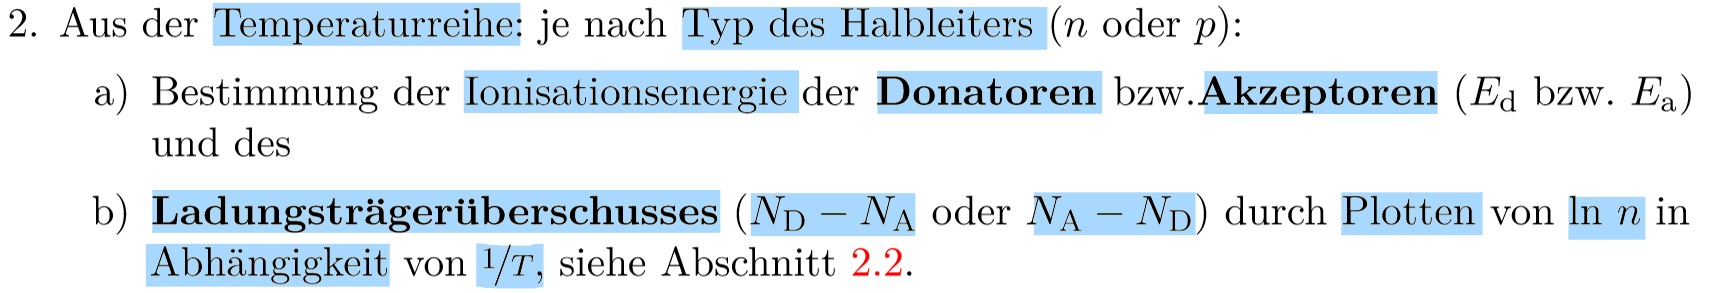

## 5. Bestimmung der Ladungsträgerdichte

In [1048]:
n = - 1 / (R_H * constants.elementary_charge)

Leider haben unsere Rechnungen auch zu einigen negativen Elektronen-Ladungsträgerdichten $n$ geführt. Da dies unphysikalisch ist und inbesondere bei unserer weiteren Analyse des $\ln{(n)}$ zu Widersprüchen führt, betrachten wir diese als Außreißer und exkludieren sie aus unseren weiteren Untersuchungen.

Folgende Zelle entfernt alle negativen Einträge von `n` UND alle korespondierenden in `temperature` bzw. `spec_resistance`; `_filtered`zeigt diese Einschränkung ab hier an.

In [1049]:
if isinstance(temperature, list):  # Falls temperature eine Liste ist, in eine Serie umwandeln
    temperature = pd.Series(temperature)

# Maske erstellen: Behalte nur Einträge mit nominalem Wert >= 0 in n
mask = n.apply(lambda x: x.n >= 0)

# Anwenden der Maske auf beide DataFrames
n_filtered = n[mask].reset_index(drop=True)
temperature_filtered = temperature[mask].reset_index(drop=True)
spec_resistance_filtered = spec_resistance[mask].reset_index(drop=True)

### Wir möchten hier Plot $1/T$ vs. $\ln{(n)}$.

`x1` und `y1` sind ALLE Werte.

In [1050]:
x1 = temperature_filtered.apply(lambda x: 1 / x)
y1 = n_filtered.apply(lambda x: um.log(x))

# für Plots / Fits braucht man immer Nominal- und Fehlerwerte getrennt
x1_value = x1.apply(lambda x: x.nominal_value)
x1_error = x1.apply(lambda x: x.std_dev)

y1_value = y1.apply(lambda x: x.nominal_value)
y1_error = y1.apply(lambda x: x.std_dev)

`x1_filtered` und `y1_filtered` sind alle Werte OHNE die ersten 7 und die letzten 6.

In [1051]:
x1_filtered = x1[7:-6]
y1_filtered = y1[7:-6]

# für Plots / Fits braucht man immer Nominal- und Fehlerwerte getrennt
x1_value_filtered = x1_filtered.apply(lambda x: x.nominal_value)
x1_error_filtered = x1_filtered.apply(lambda x: x.std_dev)

y1_value_filtered = y1_filtered.apply(lambda x: x.nominal_value)
y1_error_filtered = y1_filtered.apply(lambda x: x.std_dev)

### Linearer Hochtemperatur-Bereich:

Für die Bestimmung der Ladungsträgerdichte im Hochtemperatur-Bereich $n=N_\mathrm{D}-N_\mathrm{A} \approx N_\mathrm{D} bildeten wir den Mittelwert der ersten 7 $\ln{(n)}$, bei denen der Halbleit Raumtemperatur hatte. Die Auswahl der 7 Datenpunkte erfolgte durch Ablesen am Plot, also ohne objektives (mathematisches) Kriterium. Hier verhalten sich die Ladungsträgerdichten linear, wie im Kap. Chap{Theorie} erklärt wurde.

`x1_first7` und `y1_first7` sind alle Werte OHNE die ersten 7.

In [1052]:
x1_first7 = x1.iloc[:7]
y1_first7 = y1.iloc[:7]

# für Plots / Fits braucht man immer Nominal- und Fehlerwerte getrennt
x1_first7_value = x1_first7.apply(lambda x: x.nominal_value)
x1_first7_error = x1_first7.apply(lambda x: x.std_dev)

y1_first7_value = y1_first7.apply(lambda x: x.nominal_value)
y1_first7_error = y1_first7.apply(lambda x: x.std_dev)

# Mittelwert und dann noch exponenzieren...
n_mean = um.exp((sum(y1_first7) / len(y1_first7)))

print(f'Ladungsträgerdichte im Hochtemperatur-Bereich {n_mean} 1/m^3')

Ladungsträgerdichte im Hochtemperatur-Bereich (5.7+/-1.1)e+16 1/m^3


### Die Ladungsträgerdichte im Hochtemperatur-Bereich konnte aus den 7 Datenpunkten zu $n=N_\mathrm{D}-N_\mathrm{A} \approx N_\mathrm{D} = (2,85 \pm 0,29) \cdot 10^{14} \: \mathrm{\frac{1}{m^3}}$ bestimmt werden.

Leider musste wir durch beurteilung unseres Plots feststellen, dass die letzten 6 Datenpunkte überhaupt nicht zu den anderen passen. Dies lässt uns darauf schließen, dass es sich Messwerte mit gravierenden Messproblemen handelt. Wir behandeln diese als Außreißer und werden sie in unsere weiteren Analysen nicht miteinbeziehen.

`x1_last6` und `y1_last6` sind alle Werte OHNE die letzten 6.

In [1053]:
x1_last6 = x1.iloc[-6:]
y1_last6 = y1.iloc[-6:]

x1_last6_value = x1_last6.apply(lambda x: x.nominal_value)
x1_last6_error = x1_last6.apply(lambda x: x.std_dev)

y1_last6_value = y1_last6.apply(lambda x: x.nominal_value)
y1_last6_error = y1_last6.apply(lambda x: x.std_dev)

## 6. Bestimmung der Donator-Ionisationsenergie $E_\mathrm{d}$

### Ausfrieren von Ladungsträger:

### $n=\sqrt{N_\mathrm{D}N_\mathrm{V}}\exp{\biggl( -\frac{E_\mathrm{d}}{2k_\mathrm{B}T} \biggr)}$

### Fit-Funktion:

### $\ln{(n)}=\ln{(\sqrt{N_\mathrm{D}N_\mathrm{V}})} -\frac{E_\mathrm{d}}{2k_\mathrm{B}T}$

Um die Donator-Ionisationsenergie $E_\mathrm{d}$ zu bestimmen, formten wir

$n=\sqrt{N_\mathrm{D}N_\mathrm{V}}\exp{\biggl( -\frac{E_\mathrm{d}}{2k_\mathrm{B}T} \biggr)}$

zu

$\ln{(n)}=\ln{(\sqrt{N_\mathrm{D}N_\mathrm{V}})} -\frac{E_\mathrm{d}}{2k_\mathrm{B}T}$

um und fitteten diese an unseren Plot $1/T$ vs. $\ln{(n)}$.



In [1054]:
def fitFunction(T_inverse, NDNV, E_d):
    return np.log(np.sqrt(NDNV)) - E_d * T_inverse / (2 * constants.Boltzmann) 

popt, cov = sc.optimize.curve_fit(fitFunction, x1_value_filtered, y1_value_filtered, sigma=y1_error_filtered)
a, b = popt

x_new_value = np.arange(min(x1_value_filtered), max(x1_value_filtered), 10**-9)
y_new_value = fitFunction(x_new_value, a, b)

A = str(np.round(a, 16))
A_err = str(np.round(np.sqrt(cov[0][0]), 1))
print("Estimated value of NDNV : " + A + " +/- " + A_err + " (1/m^3)^2")

B = str(np.round(b / constants.elementary_charge, 3))
B_err = str(np.round(np.sqrt(cov[1][1]) / constants.elementary_charge, 4))
print("Estimated value of E_d : " + B + " +/- " + B_err + " eV")

Estimated value of NDNV : 1.0597151700179227e+33 +/- 8.916002294818194e+31 (1/m^3)^2
Estimated value of E_d : -0.027 +/- 0.0014 eV


Aus den Fit-Parametern erhalten wir für Ionisationsenergie der Donatoren $E_\mathrm{d} = (-27 \pm 1,4) \: \mathrm{meV}$ bzw. für den Vorfaktor $N_\mathrm{D}N_\mathrm{V}=(1,06 \pm 0,09) \cdot 10^{33} \: \mathrm{1/(m^3)^2}$.

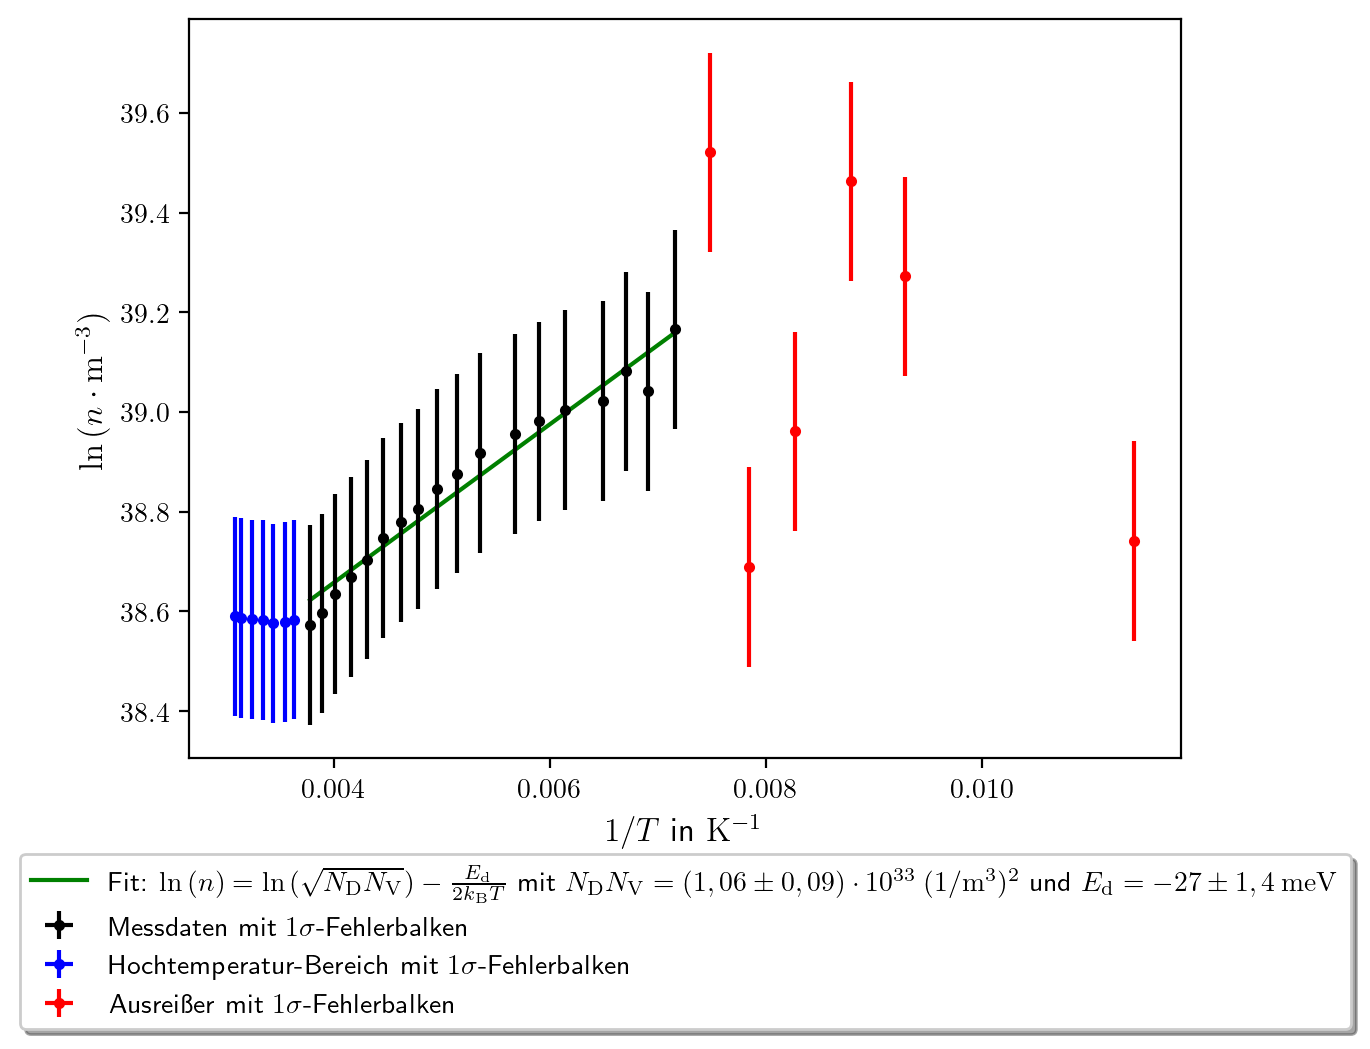

In [1055]:
plt.figure(dpi= 200)
plt.xlabel(r'$1/T$ in $\mathrm{K^{-1}}$', fontdict = font1)
plt.ylabel(r'$\ln{(n \cdot \mathrm{m^{-3}})}$', fontdict = font1)

plt.plot(x_new_value, y_new_value, color="green", label=r'Fit: $\ln{(n)}=\ln{(\sqrt{N_\mathrm{D}N_\mathrm{V}})} -\frac{E_\mathrm{d}}{2k_\mathrm{B}T}$ mit $N_\mathrm{D}N_\mathrm{V}=(1,06 \pm 0,09) \cdot 10^{33} \: \mathrm{(1/m^3)^2}$ und $E_\mathrm{d}=-27 \pm 1,4 \: \mathrm{meV}$')

# Gute Daten :)
plt.errorbar(x1_value_filtered, y1_value_filtered, yerr=y1_error_filtered, xerr=x1_error_filtered, marker=".", ls="", color="black", label=r"Messdaten mit $1 \sigma$-Fehlerbalken")
# Linearer Hochtemperatur-Bereich
plt.errorbar(x1_first7_value, y1_first7_value, yerr=y1_first7_error, xerr=x1_first7_error, marker=".", ls="", color="blue", label=r"Hochtemperatur-Bereich mit $1 \sigma$-Fehlerbalken")
# Ausreißer :(
plt.errorbar(x1_last6_value, y1_last6_value, yerr=y1_last6_error, xerr=x1_last6_error, marker=".", ls="", color="red", label=r"Ausreißer mit $1 \sigma$-Fehlerbalken")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True)
plt.show()

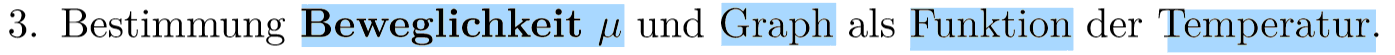

### 6. Beweglichkeit

Die Berechnung der Ladungsträgerbeweglichkeit erfolgte gemäß $\mu_\mathrm{n}=\frac{1}{\rho e n}$, wobei Abb. \ref{X} die Temeperaturabhängigkeit jeder zeigt.

In [1056]:
# Filtere aus 'spec_resistance_filtered',  'n_filtered' und 'temperature_filtered' nochmal Ausreißer raus
spec_double_resistance_filtered = spec_resistance_filtered[:-6]
n_double_filtered = n_filtered[:-6]

temperature_double_filtered = temperature_filtered[:-6]

# Berechne Beweglichkeit lt. Formel
mu = 1 / (spec_double_resistance_filtered * constants.elementary_charge * n_double_filtered)

# Nominal- und Fehlerwerte extra für Plots und Fits
mu_value = mu.apply(lambda x: x.nominal_value)
mu_error = mu.apply(lambda x: x.std_dev)
temperature_double_filtered_value = temperature_double_filtered.apply(lambda x: x.nominal_value)
temperature_double_filtered_error = temperature_double_filtered.apply(lambda x: x.std_dev)

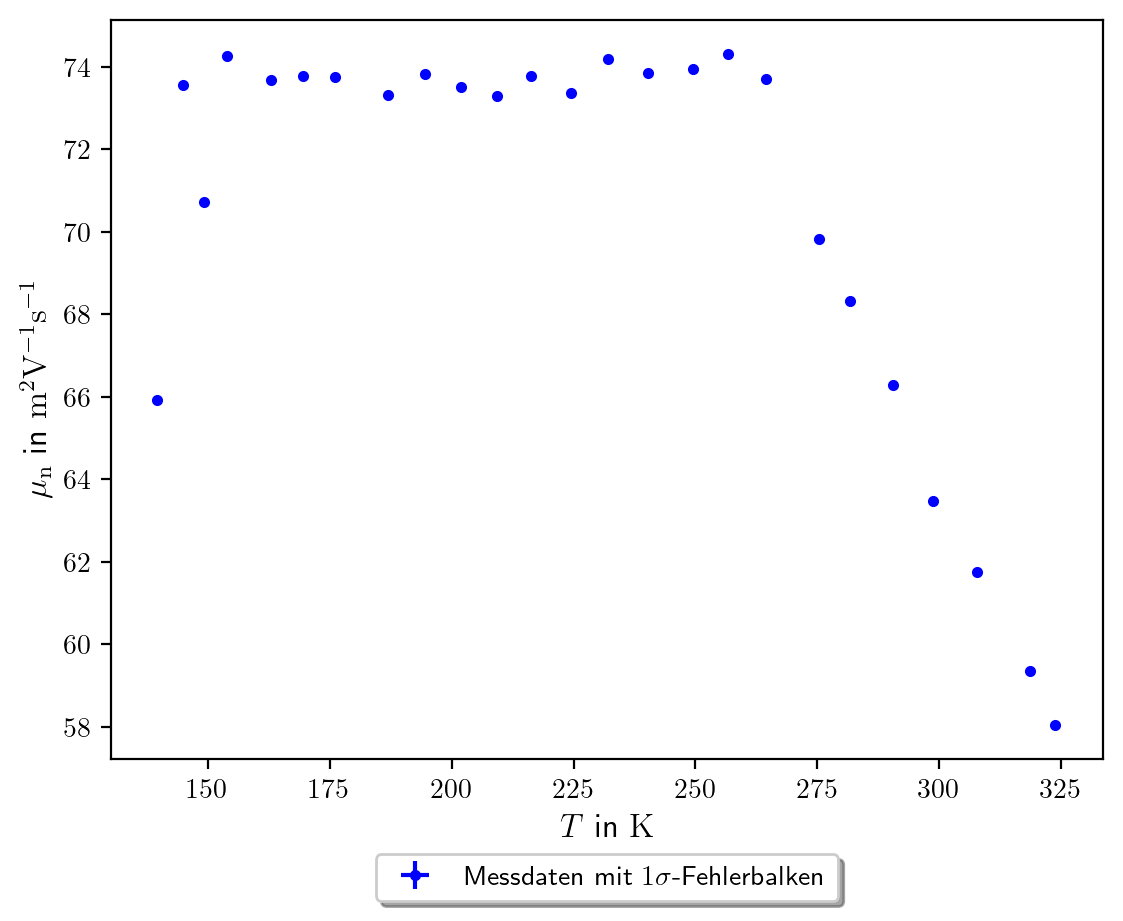

In [1057]:
plt.figure(dpi= 200)
plt.xlabel(r'$T$ in $\mathrm{K}$', fontdict = font1)
plt.ylabel(r'$\mu_\mathrm{n}$ in $\mathrm{m^2V^{-1}s^{-1}}$', fontdict = font1)
plt.errorbar(temperature_double_filtered_value, mu_value, yerr=mu_error, xerr=temperature_double_filtered_error, marker=".", ls="", color="blue", label=r"Messdaten mit $1 \sigma$-Fehlerbalken")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True)
plt.show()

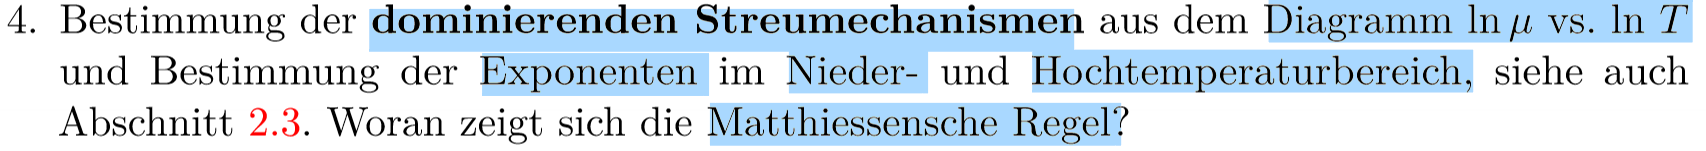

### 7. Dominierende Streumechanismen

Für die Bestimmung dominierender Streumechanismen haben wir zu aller erst ein Diagramm $\ln{(\mu_\mathrm{n})}$ gegen $\ln{(T)}$ erstellt. Dann haben wir an die Datenpunkte, die der Phonenstreuung bzw. der Streuung an ionisierten Störstellen entspricht je eine lineare Funktion angelegt, um die Propotionalität der Relaxionszeit $\tau$ zu $T^{-3/2}$ für Phononen bzw.  $T^{+3/2}$ für ionisierte Störstellen überprüfen zu können. Für die Phonenstreuung konnten wir 9 zugehörige Datenpunkte durch Ablesen am Plot ausfindig machen, für Störstellen lediglich 4, was wieder einmal von der unzureichenden Qualität unserer Messdaten bei tiefen Temperaturen zeugt.

In [1058]:
# Fitfunktion:
def linear_function(x, a, b):
    return a * x + b

`ln_temperature_double_filtered` und `ln_mu` sind ALLE Werte.

In [1059]:
ln_temperature_double_filtered = temperature_double_filtered.apply(um.log)
ln_mu = mu.apply(um.log)

ln_temperature_double_filtered_value = ln_temperature_double_filtered.apply(lambda x: x.nominal_value)
ln_temperature_double_filtered_error =ln_temperature_double_filtered.apply(lambda x: x.std_dev)

ln_mu_value = ln_mu.apply(lambda x: x.nominal_value)
ln_mu_error = ln_mu.apply(lambda x: x.std_dev)

### Ionisierte Störstellen:
`ln_temperature_double_filtered_first4` und `ln_mu_first4` sind die ersten 4 Werte.

In [1060]:
ln_temperature_double_filtered_first4 = ln_temperature_double_filtered.iloc[-4:]
ln_mu_first4 = ln_mu.iloc[-4:]

ln_temperature_double_filtered_first4_value = ln_temperature_double_filtered_first4.apply(lambda x: x.nominal_value)
ln_temperature_double_filtered_first4_error = ln_temperature_double_filtered_first4.apply(lambda x: x.std_dev)

ln_mu_first4_value = ln_mu_first4.apply(lambda x: x.nominal_value)
ln_mu_first4_error = ln_mu_first4.apply(lambda x: x.std_dev)

In [1061]:
popt3, cov3 = sc.optimize.curve_fit(linear_function, ln_temperature_double_filtered_first4_value, ln_mu_first4_value, sigma=ln_mu_first4_error)
a3, b3 = popt3

x_new_value3 = np.arange(min(ln_temperature_double_filtered_first4_value), max(ln_temperature_double_filtered_first4_value), 10**-3)
y_new_value3 = linear_function(x_new_value3, a3, b3)

A3 = str(np.round(a3, 0))
A3_err = str(np.round(np.sqrt(cov3[0][0]), 0))
print("Estimated value of a_ion: " + A3 + " +/- " + A3_err)

B3 = str(np.round(b3, 3))
B3_err = str(np.round(np.sqrt(cov3[1][1]), 0))
print("Estimated value of b_ion: " + B3 + " +/- " + B3_err + " a.u.")

Estimated value of a_ion: 1.0 +/- 1.0
Estimated value of b_ion: -0.583 +/- 3.0 a.u.


### Phononen:

`ln_temperature_double_filtered_last9` und `ln_mu_last9` sind die letzten 9 Werte.

In [1062]:
ln_temperature_double_filtered_last9 = ln_temperature_double_filtered.iloc[:9]
ln_mu_last9 = ln_mu.iloc[:9]

ln_temperature_double_filtered_last9_value = ln_temperature_double_filtered_last9.apply(lambda x: x.nominal_value)
ln_temperature_double_filtered_last9_error = ln_temperature_double_filtered_last9.apply(lambda x: x.std_dev)

ln_mu_last9_value = ln_mu_last9.apply(lambda x: x.nominal_value)
ln_mu_last9_error = ln_mu_last9.apply(lambda x: x.std_dev)

In [1063]:
popt2, cov2 = sc.optimize.curve_fit(linear_function, ln_temperature_double_filtered_last9_value, ln_mu_last9_value, sigma=ln_mu_last9_error)
a2, b2 = popt2

x_new_value2 = np.arange(min(ln_temperature_double_filtered_last9_value), max(ln_temperature_double_filtered_last9_value), 10**-3)
y_new_value2 = linear_function(x_new_value2, a2, b2)

A2 = str(np.round(a2, 2))
A2_err = str(np.round(np.sqrt(cov2[0][0]), 2))
print("Estimated value of a_ph: " + A2 + " +/- " + A2_err)

B2 = str(np.round(b2, 2))
B2_err = str(np.round(np.sqrt(cov2[1][1]), 2))
print("Estimated value of b_ph: " + B2 + " +/- " + B2_err + " a.u.")

Estimated value of a_ph: -1.1 +/- 0.04
Estimated value of b_ph: 10.44 +/- 0.2 a.u.


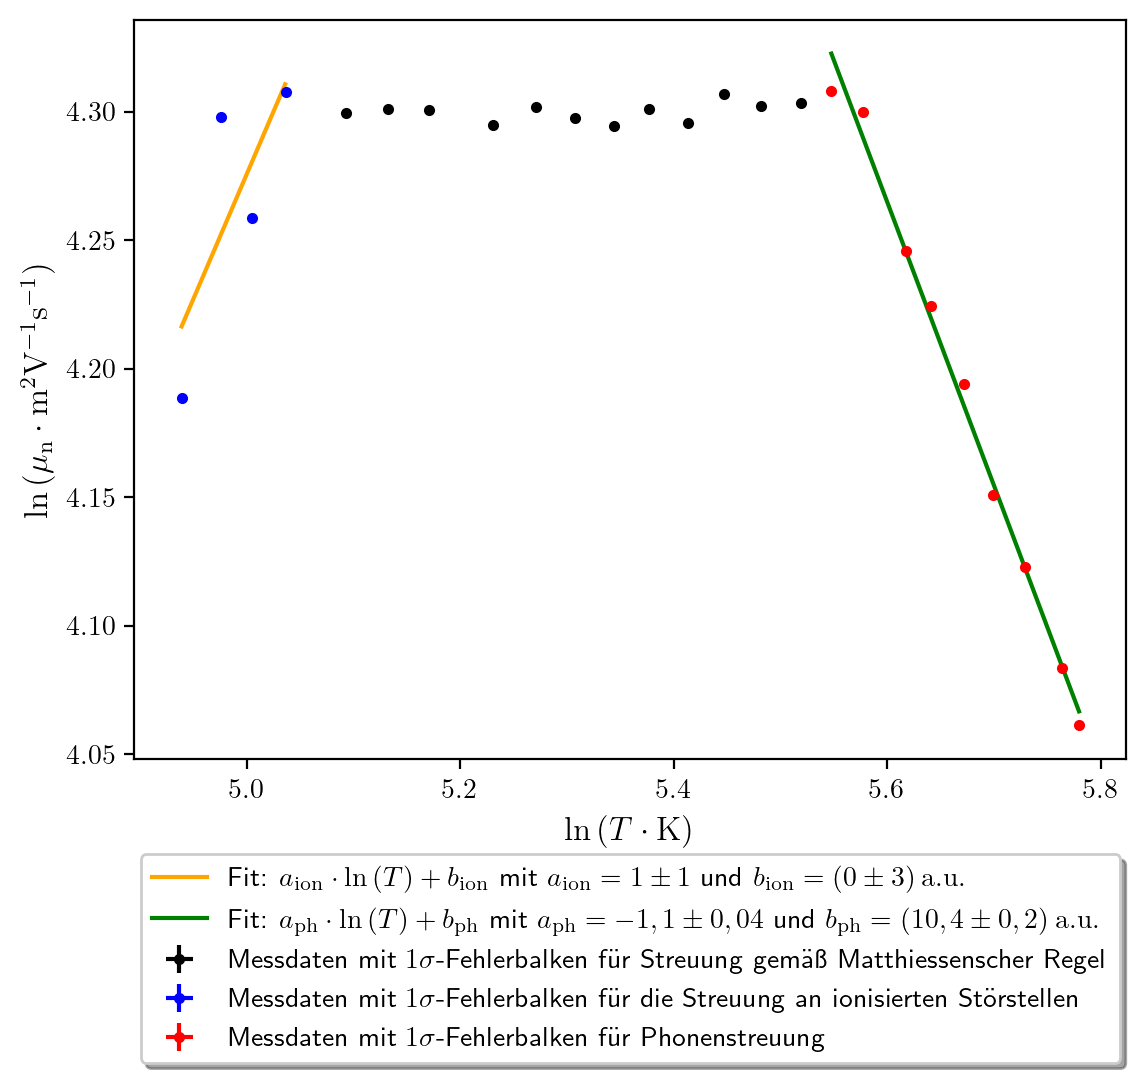

In [1064]:
plt.figure(dpi= 200)
plt.xlabel(r'$\ln{(T \cdot \mathrm{K})}$', fontdict = font1)
plt.ylabel(r'$\ln{(\mu_\mathrm{n} \cdot \mathrm{m^2V^{-1}s^{-1}})}$', fontdict = font1)

# Matthiessensche Regel
plt.errorbar(ln_temperature_double_filtered_value[9:-4], ln_mu_value[9:-4], yerr=ln_mu_error[9:-4], xerr=ln_temperature_double_filtered_error[9:-4], marker=".", ls="", color="black", label=r"Messdaten mit $1 \sigma$-Fehlerbalken für Streuung gemäß Matthiessenscher Regel")

# ionisierten Störstellen
plt.errorbar(ln_temperature_double_filtered_first4_value, ln_mu_first4_value, yerr=ln_mu_first4_error, xerr=ln_temperature_double_filtered_first4_error, marker=".", ls="", color="blue", label=r"Messdaten mit $1 \sigma$-Fehlerbalken für die Streuung an ionisierten Störstellen")
plt.plot(x_new_value3, y_new_value3, color="orange", label=r'Fit: $a_\mathrm{ion} \cdot \ln{(T)} + b_\mathrm{ion}$ mit $a_\mathrm{ion}=1 \pm 1$ und $b_\mathrm{ion}=(0 \pm 3) \: \mathrm{a.u.}$')

# Phonenstreuung
plt.errorbar(ln_temperature_double_filtered_last9_value, ln_mu_last9_value, yerr=ln_mu_last9_error, xerr=ln_temperature_double_filtered_last9_error, marker=".", ls="", color="red", label=r"Messdaten mit $1 \sigma$-Fehlerbalken für Phonenstreuung")
plt.plot(x_new_value2, y_new_value2, color="green", label=r'Fit: $a_\mathrm{ph} \cdot \ln{(T)} + b_\mathrm{ph}$ mit $a_\mathrm{ph}=-1,1 \pm 0,04$ und $b_\mathrm{ph}=(10,4 \pm 0,2) \: \mathrm{a.u.}$')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True)
plt.show()

Zu guter Letzt möchten wir noch die Übereinstimmung der Exponenten aus Theorie und Experiment überprüfen. Für die Phonenstreuung gilt $a_\mathrm{ph,theo}=-3/2$ (Theoriewert) und $a_\mathrm{ph,exp}=-1,1 \pm 0,04$ (Experimenteller Wert), welche demnach $10 \sigma$ von einander abweichen. Für die Streuung an ionisierten Störstellen gilt allerdings $a_\mathrm{ion,theo}=+3/2$ (Theoriewert) und $a_\mathrm{ion,exp}=1 \pm 1$ (Experimenteller Wert), was einer relativen Abweichung von $0.5 \sigma$ entspricht. Das 
Ergebnis für die Störstellen ist allerdings nicht so zu gebrauchen, da der Fehler gleich groß wie der Messwert ist. In anderen Worten liefert der Fit einfach ein unzureichendes Ergebnis, da er nur 4 Datenpunkte miteinbezieht. Wir sind deswegen der Meinung, die Streuung an Phononen trotz der Abweichung von $10 \sigma$ nachgewiesen zu haben, die Streuung von Elektronen an Störstellen benötigt jedoch mehr Messdaten im Niedertemperaturbereich, als dass hierüber sinnvoll Aussage getroffen werden kann.